In [12]:
import numpy as np
import pandas as pd
import os
import SimpleITK as sitk
from glob import glob

import matplotlib.pyplot as plt

### read annotations.csv and candidates.csv // paths

In [13]:
data_path = '../dataset/'
SET_DIR = '../sets/base/'
TRAIN_IMG_DIR = SET_DIR + 'nodules/train/'
TEST_IMG_DIR = SET_DIR + 'nodules/test/'
VAL_IMG_DIR = SET_DIR + 'nodules/val/'
IMG_PREF = 'nodule_'
IMG_EXT = '.jpg'

annot_df = pd.read_csv(data_path + 'CSVFILES/annotations.csv')
cand_df = pd.read_csv(data_path + 'CSVFILES/candidates.csv')

In [14]:
pos_ind = cand_df[cand_df['class'] == 1].index
neg_ind = cand_df[cand_df['class'] == 0].index 

print(len(pos_ind))
print(len(neg_ind))

1351
549714


### change set size here

### read pickle

In [15]:
X_train = pd.read_pickle(SET_DIR + 'pickle/traindata')
X_test = pd.read_pickle(SET_DIR + 'pickle/testdata')
X_val = pd.read_pickle(SET_DIR + 'pickle/valdata')
y_train = pd.read_pickle(SET_DIR + 'pickle/trainlabels')
y_test = pd.read_pickle(SET_DIR + 'pickle/testlabels')
y_val = pd.read_pickle(SET_DIR + 'pickle/vallabels')

In [16]:
print('TRAINING DATA')
print('Total examples: ', len(y_train))
print('Total positives: ', y_train.sum())
print(format((y_train.sum() / len(y_train)) * 100, '.2f'), '%')

TRAINING DATA
Total examples:  11888
Total positives:  1075
9.04 %


### create h5py files

In [17]:
import h5py
import PIL

In [26]:
def create_h5py(mode):
    if mode == 'train':
        X = X_train
        y = y_train
        DIR = TRAIN_IMG_DIR
    elif mode == 'test':
        X = X_test
        y = y_test
        DIR = TEST_IMG_DIR
    elif mode == 'val':
        X = X_val
        y = y_val
        DIR = VAL_IMG_DIR
    
    f = h5py.File('../h5py/malaCAD' + mode + '.hdf5', 'w')
    
    # Create classes (labels) dataset
    f.create_dataset(mode + '_labels', shape = (len(y),))
    f[mode + '_labels'][...] = list(y)
    
    # Create images dataset
    f.create_dataset(mode + '_img', shape = (len(X), 50, 50))
    index = 0
    for col in X.transpose():
        image = PIL.Image.open(DIR + IMG_PREF + str(col) + IMG_EXT)
        f[mode + '_img'][index, ...] = image
        index += 1
    
    f.close()
    
    f = h5py.File('../h5py/malaCAD' + mode + '.hdf5', 'r')
    X_ret = f[mode + '_img'] [...]
    y_ret = f[mode + '_labels'][...]
    f.close()
    
    return (X_ret, y_ret)

In [27]:
input_train, label_train = create_h5py('train')
input_test, label_test = create_h5py('test')
input_val, label_val = create_h5py('val')

## CNN

In [29]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

In [35]:
# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 50, 50, 1
loss_function = sparse_categorical_crossentropy
no_classes = 2
no_epochs = 5
optimizer = Adam()
validation_split = 0.2
verbosity = 1

In [36]:
# Reshape data
input_train = input_train.reshape(len(input_train), img_width, img_height, img_num_channels)
input_test = input_test.reshape(len(input_test), img_width, img_height, img_num_channels)
input_val = input_val.reshape(len(input_val), img_width, img_height, img_num_channels)

input_shape = (img_width, img_height, img_num_channels)

In [41]:
print(len(input_train))
print(len(input_test))
print(len(input_val))

11888
2973
2973


In [37]:
# Create the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))

# Display a model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 44, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 247808)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               31719552  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 31,812,482
Trainable params: 31,812,482
Non-trainable params: 0
__________________________________________

In [38]:
# Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

### train model

In [42]:
model.fit(input_train, label_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_data=(input_val, label_val))

Train on 11888 samples, validate on 2973 samples
Epoch 1/5
11888/11888 [==============================] - 136s 11ms/sample - loss: 2.7443 - accuracy: 0.9069 - val_loss: 0.2335 - val_accuracy: 0.9169
Epoch 2/5
11888/11888 [==============================] - 134s 11ms/sample - loss: 0.1907 - accuracy: 0.9360 - val_loss: 0.2118 - val_accuracy: 0.9196
Epoch 3/5
11888/11888 [==============================] - 133s 11ms/sample - loss: 0.1360 - accuracy: 0.9547 - val_loss: 0.2364 - val_accuracy: 0.9216
Epoch 4/5
11888/11888 [==============================] - 134s 11ms/sample - loss: 0.1006 - accuracy: 0.9672 - val_loss: 0.3267 - val_accuracy: 0.9041
Epoch 5/5
11888/11888 [==============================] - 132s 11ms/sample - loss: 0.1095 - accuracy: 0.9605 - val_loss: 0.2992 - val_accuracy: 0.9119


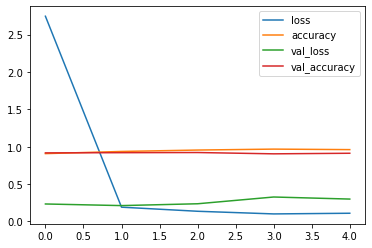

In [43]:
pd.DataFrame(model.history.history).plot()

### save model

In [44]:
model.save('../models/new_cnn_model.h5')

### predict

In [45]:
score = model.evaluate(input_test, label_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.10158259495015182 / Test accuracy: 0.9707366228103638


In [46]:
from sklearn.metrics import confusion_matrix, classification_report

preds = model.predict_classes(input_test)

print(confusion_matrix(label_test, preds))
print(classification_report(label_test, preds))

[[2685   56]
 [  31  201]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      2741
         1.0       0.78      0.87      0.82       232

    accuracy                           0.97      2973
   macro avg       0.89      0.92      0.90      2973
weighted avg       0.97      0.97      0.97      2973

